In [1]:
InteractiveShell.ast_node_interactivity = 'last_expr'
%config InlineBackend.figure_format = 'retina'

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from astropy import units as u
from astropy import constants as c
import yssbtmpy_ana2021 as tm
import xarray as xr
from scipy.optimize import curve_fit


from matplotlib import pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from matplotlib.patches import Circle, FancyArrowPatch, Arc
from matplotlib.ticker import LogLocator

from multiprocessing import Pool


from accutil import (
    wrap_000360_to_180180, wrap_180180_to_000360, 
    set_perpmodel, set_phaethon, set_model_aspect,
    set_particle, linticker, set_spl, 
    logxticker, logyticker, logticker, calc_traj, CHEMDICT, PHYS_PHAE,
    QprbarSpline, QprbarSunSpline, QPRDIR)

In [3]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

In [4]:
# RADII = np.concatenate([np.arange(0.5, 1, 0.1),
#                        np.arange(2, 16.1, 0.5),
#                        np.arange(20, 41, 5)])
# RADII = np.concatenate([np.arange(0.5, 0.99, 0.05),
#                        np.arange(1, 1.99, 0.1),
#                        np.arange(2, 2.99, 0.2),
#                        np.logspace(np.log10(3), np.log10(60), 15)
#                        ])
# DIAMS = np.arange(0.5, 30, 0.5) * u.km 
# DIAMS = np.concatenate([np.arange(0.2, 1.99, 0.1),
#                         np.arange(2.0, 2.99, 0.2),
#                         np.logspace(np.log10(3), np.log10(80), 15)
#                        ]) * u.km 

RADII = np.logspace(np.log10(0.5), np.log10(60), 50)
DIAMS = np.logspace(np.log10(0.1), np.log10(80), 50)*u.km
RHELS = np.logspace(-1, np.log10(2), 25)*u.au

FIGDIR = Path("./figs")
DATADIR = Path("./data")
PH_0_CALC = np.arange(0., 360., 1.)
TH_0_CALC = np.arange(10, 171, 10)

ASPANGS = np.array([90, 45])*u.deg
PROTS = np.array([3, 6]) * u.h
TRUE_ANOMS = np.arange(0, 360, 15)

TPM_BASE = dict(a_bond=0.05, 
                ti=200, 
                bulk_mass_den=2000*u.kg/u.m**3, 
                emissivity=0.90,
                nlon=360,
                nlat=3)

chemkeys = list(CHEMDICT.keys())
n_chem = len(chemkeys)
n_radii = len(RADII)

##### For xarray setup #####
'''
* asp = aspect angle
* r_h = heliocentric distance
* chem = chemical composition 
* D = effective diameter in km
* P = rotational period in h
* r = particle radius in um
* ph = initial longitudinal position (0 ~ 360 deg)
'''
N_ASP = ASPANGS.shape[0]
N_RH = RHELS.shape[0]
N_D = DIAMS.shape[0]
N_P = PROTS.shape[0]
N_R = RADII.shape[0]
N_PH = PH_0_CALC.shape[0]
N_TH = TH_0_CALC.shape[0]
N_F = TRUE_ANOMS.shape[0]

XRDIMS1 = ('asp', 'r_h', 'chem', 'D', 'P', 'r', 'ph')
XRCOOR1 = dict(
    asp=ASPANGS.value,
    r_h=RHELS.value,
    chem=chemkeys,
    D=DIAMS.value,
    P=PROTS.value,
    r=RADII,
    ph=PH_0_CALC
)
XRUNIT1 = dict(asp=u.deg, r_h=u.au, chem='', D=u.km, P=u.h, r=u.um, ph=u.deg)

XRDIMS2 = ('chem', 'f', 'r', 'th', 'ph')
XRCOOR2 = dict(
    chem=chemkeys,
    f=TRUE_ANOMS,
    r=RADII,
    th=TH_0_CALC,
    ph=PH_0_CALC
)
XRUNIT2 = dict(chem='', f=u.deg, r=u.um, th=u.deg, ph=u.deg)
####################################

## One-Time Calcuation
Calculate the accelerations depending on the parameters (diameter, rotational period, true anomaly, particle radius, longitude, and latitude):

In [5]:
######### multi thread case ########
# TI_RHCORR = True
TI_RHCORR = False

a_fict_path = DATADIR/f"acc_fictmodels_ti{TPM_BASE['ti']:.0f}.nc"
npool_optimal = 7

if not a_fict_path.exists():
    m_ficts = {}
    for asp in ASPANGS:
        for rh in RHELS:
            for d in DIAMS:
                for p in PROTS:
                    m_fict = set_model_aspect(r_hel=rh, aspect_deg=asp, 
                                              diam_eff=d, rot_period=p, 
                                              **TPM_BASE)
                    m_fict.calc_temp(full=False)
                    m_ficts[asp, rh, d, p] = m_fict

In [6]:
if not a_fict_path.exists():
    a_ficts = np.zeros((N_ASP, N_RH, 2, N_D, N_P, N_R, N_PH))
    for i_c, chem in enumerate(chemkeys):
        # Splining Qprbar is the most time-consuming part (~ 20ms)
        # compared to all others (< 1ms), so better to give a priori if possible.
        kw_Q = dict(Qprbar_sun=QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv"), 
                    Qprbar_ther=QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv"))
        print(chem, end=' ')
        for i_asp, asp in enumerate(ASPANGS):
            print(asp)
            for i_rh, rh in enumerate(RHELS):    
                print(f"{rh:.2f}", end=' ')
                for i_d, d in enumerate(DIAMS):
                    print('.', end='')
                    for i_p, p in enumerate(PROTS):
                        sb_fict = m_ficts[asp, rh, d, p]
                        for i_r, radius in enumerate(RADII):
                            acc_fict = []
                            for ph in PH_0_CALC:
                                p = set_particle(sb_fict, radius_um=radius, chem=chem, init_th=90, init_ph=ph, **kw_Q)
                                acc_fict.append(np.sum(p.trace_a_all_xyz[-1]*p.trace_rvec[-1]))
                            acc_fict = np.array(acc_fict)
                            a_ficts[i_asp, i_rh, i_c, i_d, i_p, i_r] = acc_fict
# 2021-04-26: the following started not working, IDK why...
#                         def _acc_multi(radius):  # d, p, sb, Qpr are already defined outside.
#                             acc_fict = []
#                             for ph in PH_0_CALC:
#                                 kw_p = dict(radius_um=radius, chem=chem, 
#                                             init_th=90, init_ph=ph, **kw_Q)
#                                 p = set_particle(sb_fict, **kw_p)
#                                 acc_fict.append(np.sum(p.trace_a_all_xyz[-1]
#                                                        * p.trace_rvec[-1]))
#                             return radius, np.array(acc_fict)
#                         with Pool(npool_optimal) as pool:
#                             pool = Pool(npool_optimal)
#                             args = [RADII]
#                             results = np.array(pool.starmap(_acc_multi, np.array(args).T))
#                             pool.close()
#                             for i_r, res in enumerate(results):
#                                 a_ficts[i_asp, i_rh, i_c, i_d, i_p, i_r] = res[1]
                print('')
    a_fict = xr.Dataset(
        {'fict': (XRDIMS1, a_ficts)},
        coords=XRCOOR1)

    for k, v in XRUNIT1.items():
        a_fict['fict'][k].attrs['units'] = str(v)

    a_fict.to_netcdf(a_fict_path)

a_fict = xr.open_dataset(a_fict_path)
# a_perps = np.load(a_perps_path, allow_pickle=True)[()]
# a_th45s = np.load(a_th45s_path, allow_pickle=True)[()]


a_phaes_path = DATADIR/f"acc_phae.nc"
    
if not a_phaes_path.exists():
    m_phaes = {}
    for f in TRUE_ANOMS:
        m_phae = set_phaethon(true_anom=f, ti=PHYS_PHAE['ti'])
        m_phae.calc_temp(full=False)
        m_phaes[f] = m_phae

    a_phaes = np.zeros((2, N_F, N_R, N_TH, N_PH))
    for i_c, chem in enumerate(chemkeys):
        # Splining Qprbar is the most time-consuming part (~ 20ms)
        # compared to all others (< 1ms), so better to give a priori if possible.
        kw_Q = dict(Qprbar_sun=QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv"), 
                    Qprbar_ther=QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv"))
        print(chem, end=' ')
        for i_f, f in enumerate(TRUE_ANOMS):
            print(f, end=' ')
            sb_phae = m_phaes[f]
            for i_r, radius in enumerate(RADII):
                acc_phae = []
                for ph in PH_0_CALC:
                    p = set_particle(sb_phae, radius_um=radius, chem=chem, init_th=90, init_ph=ph, **kw_Q)
                    acc_phae.append(np.sum(p.trace_a_all_xyz[-1]*p.trace_rvec[-1]))
                acc_phae = np.array(acc_phae)
                a_phaes[i_c, i_f, i_r] = acc_phae

# 2021-04-26: the following started not working, IDK why...
#             def _acc_multi(radius):  # f, sb, Qpr are already defined outside.
#                 acc_phae = np.zeros((N_TH, N_PH))
#                 for i_th, th in enumerate(TH_0_CALC):
#                     for i_ph, ph in enumerate(PH_0_CALC):
#                         kw_p = dict(radius_um=radius, chem=chem, 
#                                     init_th=th, init_ph=ph, **kw_Q)
#                         p_phae = set_particle(sb_phae, **kw_p)
#                         acc_phae[i_th, i_ph] = (np.sum(p_phae.trace_a_all_xyz[-1]
#                                                 * p_phae.trace_rvec[-1]))
#                 return radius, acc_phae

#             pool = Pool(npool_optimal)
#             args = [RADII]
#             results = np.array(pool.starmap(_acc_multi, np.array(args).T))
#             pool.close()
#             for i_r, res in enumerate(results):
#                 a_phaes[i_c, i_f, i_r] = res[1]
    a_phae = xr.Dataset(
        {'h18': (XRDIMS2, a_phaes)},
        coords=XRCOOR2)

    for mod_id in ['h18']:
        for k, v in XRUNIT2.items():
            a_phae[mod_id][k].attrs['units'] = str(v)

    a_phae.to_netcdf(a_phaes_path)

a_phae = xr.open_dataset(a_phaes_path)

# Change true anomaly to -180 ~ +180
a_phae = a_phae.assign_coords(f=wrap_000360_to_180180(a_phae.f))
a_phae = a_phae.sortby('f')

print("Loading and Setting Finished.")

Loading and Setting Finished.


The reason I used ``npool_optimal = 7`` is because using 7 thread seemed the fastest for my laptop (see **Timing Benchmark** section below).

<details><summary><b>single thread case</b> (click)</summary>
<p>

```python
######### single thread case ########
a_perps = {}
a_th45s = {}
a_phaes = {}

for chem in chemkeys:
    # Splining Qprbar is the most time-consuming part (~ 20ms)
    # compared to all others (< 1ms), so better to give a priori if possible.
    kw_Q = dict(Qprbar_sun=QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv"), 
                Qprbar_ther=QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv"))
    for d in DIAMS:
        for p in PROTS:
            sb_perp = m_perps[d, p]
            sb_th45 = m_th45s[d, p]
            for r in RADII:
                print(f"{r:.1f}", end=' ')
                acc_perp = []
                acc_th45 = []
                for ph in PH_0_CALC:
                    kw_p = dict(radius_um=r, chem=chem, 
                                init_th=90, init_ph=ph, **kw_Q)
                    particle_perp = set_particle(sb_perp, **kw_p)
                    particle_th45 = set_particle(sb_th45, **kw_p)
                    a_perp = np.sum(particle_perp.trace_a_all_xyz[-1]
                                    *particle_perp.trace_rvec[-1])
                    a_th45 = np.sum(particle_th45.trace_a_all_xyz[-1]
                                    *particle_th45.trace_rvec[-1])
                    acc_perp.append(a_perp)
                    acc_th45.append(a_th45)
                a_perps[d, p, r] = np.array(acc_perp)
                a_th45s[d, p, r] = np.array(acc_th45)
# a_perps = np.load(a_perps_path, allow_pickle=True)[()]
# a_th45s = np.load(a_th45s_path, allow_pickle=True)[()]
```
</p>
</details>

## Fictitious Models
Perpendicular & Aspect 45˚ Model

In [7]:
def plot_size_size(r_h_plot, lvs, lws, kws):
    fig, axs = plt.subplots(len(ASPANGS)*len(PROTS), 
                            len(r_h_plot), 
                            figsize=(3.5*len(r_h_plot), 4*len(ASPANGS)*len(PROTS)), 
                            sharex=False, sharey=False)
    modelname = lambda asp: "Perpendicular model" if asp==ASPANGS[0] else f"Aspect {asp.value:.0f}˚ model"
    
    for i_asp, asp in enumerate(ASPANGS):
        for i_prot, prot in enumerate(PROTS[::-1]):
            for axa, r_h in zip(axs[i_asp*2 + i_prot, :], r_h_plot):
                arr = a_fict.fict.sel(asp=asp, r_h=r_h)
                x = arr.D
                y = arr.r
                a_cen = np.tile(x/2 * (2*np.pi/(prot*3600))**2, (N_R, 1))

                # m/s^2 to mm/s^2
                max_o = 1000*(a_cen + arr.sel(chem='oliv', P=prot).max(dim='ph').T)
                max_m = 1000*(a_cen + arr.sel(chem='mag', P=prot).max(dim='ph').T)
                axa.set(
                    yscale='log', 
                    xscale='log', 
                    xlim=(0.09, 90),
                    ylim=(0.46, 75),
                    xlabel="Asteroid diameter $D$ [km]",
                    ylabel='Particle radius $r_a$ [µm]',
                    title = f"{modelname(asp)}\n $P_\mathrm{{rot}} = {prot.value:.0f} \,\mathrm{{h}}$, $r_\mathrm{{h}} = {r_h.value:.2f}$ au"
                    )
                for k, arr in zip(['o', 'm'], [max_o, max_m]):
                    c = kws[k]['c']
                    l = kws[k]['lab']
                    ls = kws[k]['ls']
                    cm = kws[k]['cmap']
                    ca = kws[k]['calpha']
                    axa.contourf(x, y, arr, levels=lvs, cmap=cm, alpha=ca)
                    cs = axa.contour(x, y, arr, levels=lvs, linewidths=lws, 
                                     colors=c, linestyles=ls)
                    cs.clabel(fmt="%.0f", colors=c)
                    axa.plot(np.nan, np.nan, f"{c}{ls}", label=l)

#                 [axa.axvline(x, color='k', ls=':', lw=0.1) for x in DIAMS.value]
#                 [axa.axhline(y, color='k', ls=':', lw=0.1) for y in RADII]
                    
                logticker(axa, xmajgrids=False, ymajgrids=False, xmingrids=False, ymingrids=False)
#                 axa.legend(
#                     loc=1, 
#                     title=(r"$\mathrm{max}(\mathbf{a}_\mathrm{total} \cdot \hat{\mathbf{r}}) ~[\mathrm{mm/s^2}]$")
#                 )

    for i, ax in enumerate(axs.flatten()):
        ax.text(x=-0.20, y=1.03, s=chr(ord('a') + i), transform=ax.transAxes, 
                fontsize=18, fontweight='bold', va='bottom', ha='left')


    # plt.suptitle("Fictitious models equator", y=1.02)
    plt.tight_layout()
    fig.align_ylabels(axs)
    fig.align_xlabels(axs)


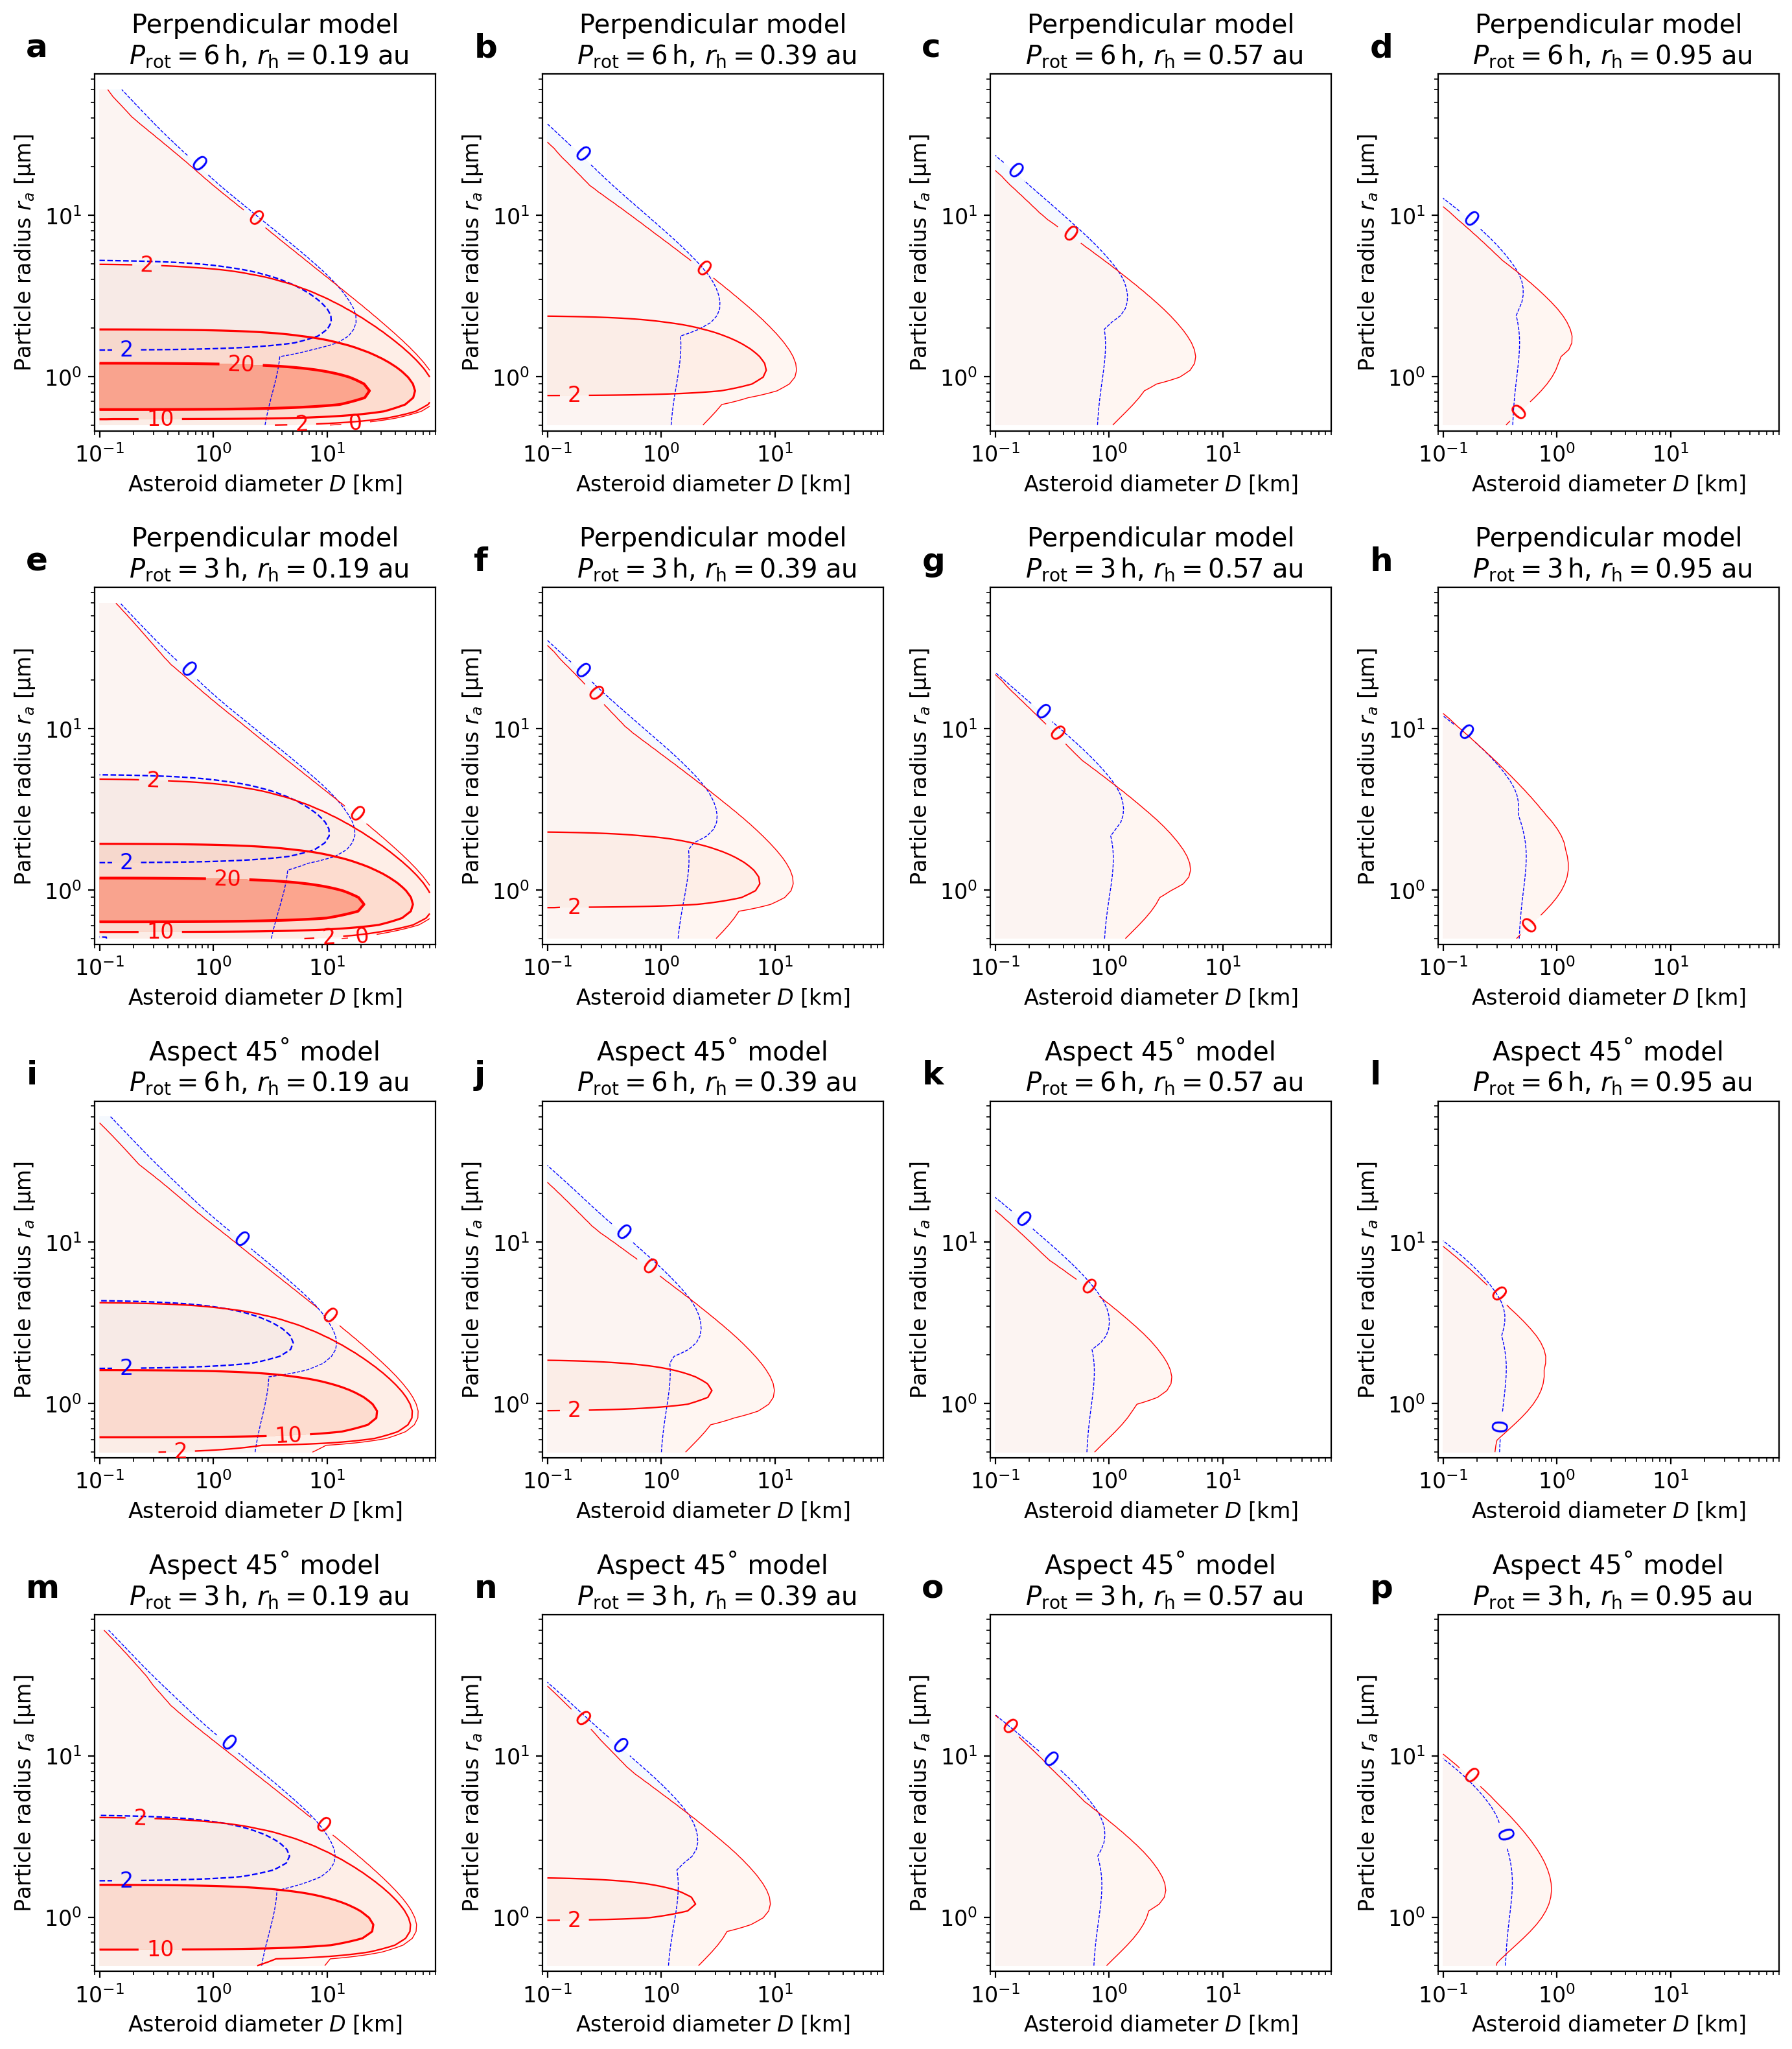

In [8]:
r_h_plot = [RHELS[5], RHELS[11], RHELS[14], RHELS[18]]
            
kws = dict(
    o=dict(c='b', lab='olivine', ls='--', cmap='Blues', calpha=1),
    m=dict(c='r', lab='magnetite', ls='-', cmap='Reds', calpha=0.7),
)
lvs = [0.01, 2, 10, 20, 50, 60, 80]
lws = .5 + np.arange(len(lvs))/3

plot_size_size(r_h_plot=r_h_plot, lvs=lvs, lws=lws, kws=kws)

plt.savefig(FIGDIR/f"size-size_all.pdf")
plt.savefig(FIGDIR/f"size-size_all.png", dpi=300)

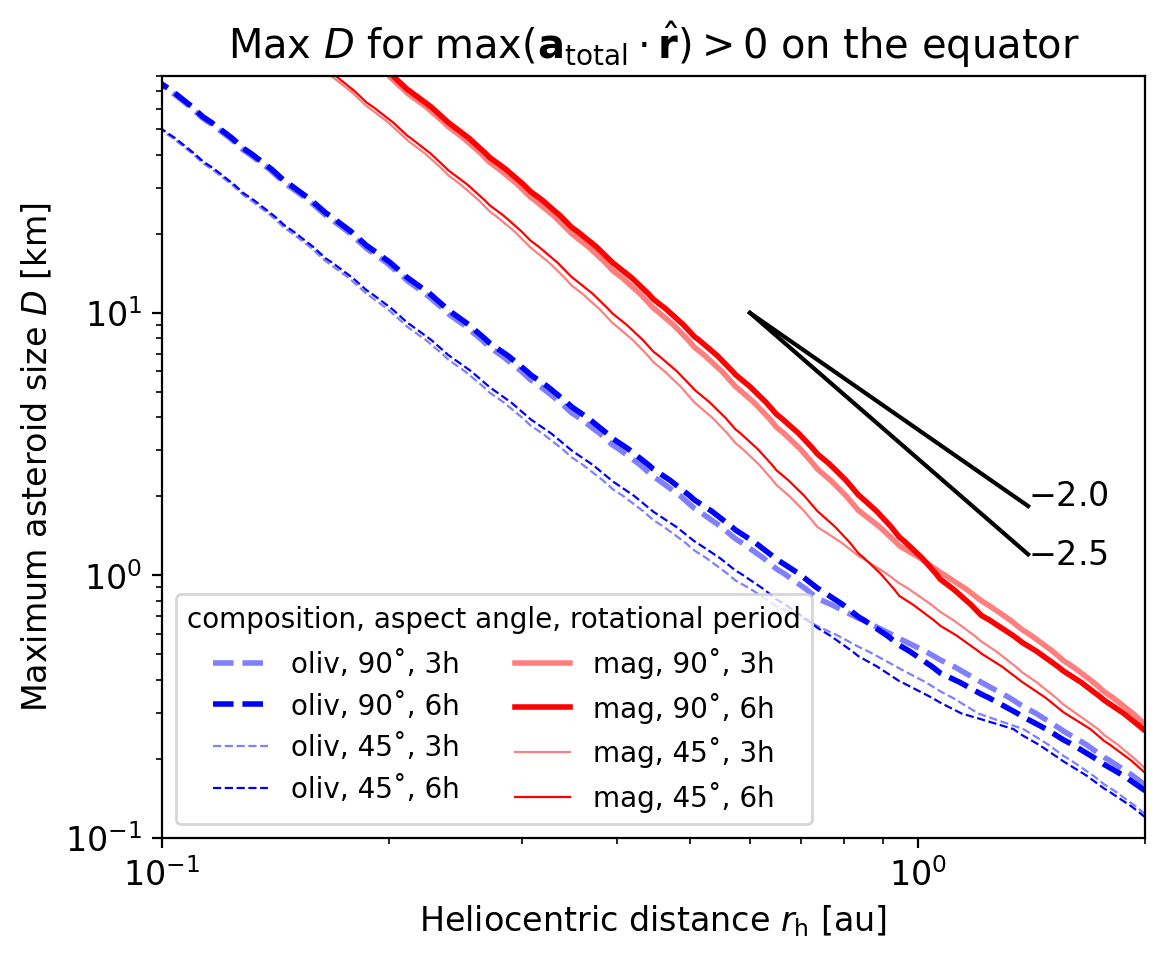

In [9]:
def powf(d1, a):
    return 

def fitloglin(x, y):
    popt, pcov = curve_fit(linf, np.log10(x), np.log10(y))
    
maxacc = a_fict.fict.max(['r', 'ph']) 

lss = ['--', '-']
colors = ['b', 'r']
lws = [2, 0.8]
alphas = [0.5, 1]

fig, axs = plt.subplots(1, 1, figsize=(6, 5), sharex=False, sharey=False, gridspec_kw=None)

labstr = "{}, {:.0f}˚, {:.0f}h"
for chem, color, ls in zip(a_fict.coords['chem'], colors, lss):
    for asp, lw in zip(a_fict.coords['asp'], lws):
        for prot, alpha in zip(a_fict.coords['P'], alphas):
            arr = maxacc.sel(asp=asp, chem=chem, P=prot)
            c = axs.contour(a_fict.coords["r_h"], a_fict.coords["D"], arr.T, 
                            levels=0, linestyles=ls, colors=color, linewidths=lw, alpha=alpha)
            axs.plot(np.nan, np.nan, label=labstr.format(chem.values, asp.values, prot.values),
                    ls=ls, color=color, lw=lw, alpha=alpha)
x1, x2, y0 = 0.6, 1.4, 10
y1 = y0*(x2/x1)**(-2.0)
y2 = y0*(x2/x1)**(-2.5)
axs.plot((x1, x2), (y0, y1), 'k-')
axs.plot((x1, x2), (y0, y2), 'k-')
axs.text(x2, y1, r"$-2.0$")
axs.text(x2, y2-0.1, r"$-2.5$")
            
leg = axs.legend(loc=3, ncol=2, fontsize=10)
leg.set_title("composition, aspect angle, rotational period", prop={'size': 10})

axs.set(
    xscale='log', 
    yscale='log',
    title=r"Max $ D $ for $ \mathrm{max}({\mathbf{a}_\mathrm{total} \cdot \hat{\mathbf{r}}}) > 0 $ on the equator",
    xlabel=r"Heliocentric distance $r_\mathrm{h}$ [au]", ylabel=r"Maximum asteroid size $ D $ [km]"
)
logticker(axs, xmajgrids=False, ymajgrids=False, xmingrids=False, ymingrids=False)
plt.tight_layout()

plt.savefig(FIGDIR/"rh_diammax.pdf")
plt.savefig(FIGDIR/"rh_diammax.png", dpi=300)

[ 0.74720592 -2.03088962]
[ 1.04039914 -2.45428972]


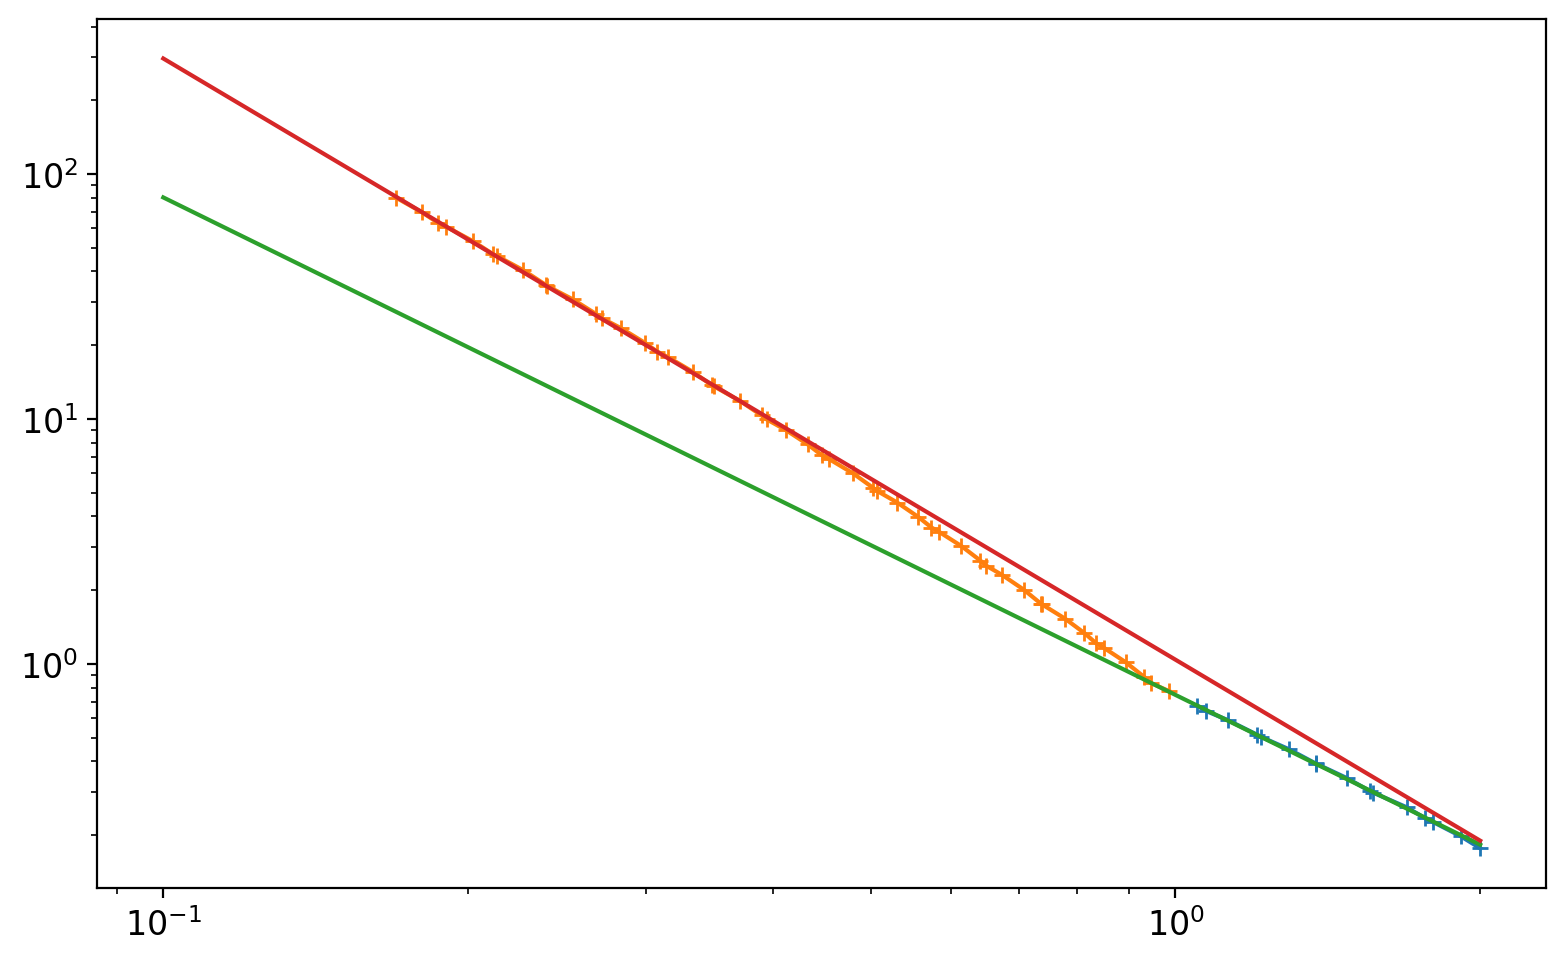

In [10]:
def testf(x, a, b):
    return a*x**b
#     return a*np.exp(x*b)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

xy = c.allsegs[1][0]
mask1au = xy[:, 0] > 1
xl, xh = xy[~mask1au, 0], xy[mask1au, 0]
yl, yh = xy[~mask1au, 1], xy[mask1au, 1]
popth, _ = curve_fit(testf, xh, yh)
poptl, _ = curve_fit(testf, xl, yl)
print(popth)
print(poptl)

# axs.contour(a_fict.coords["r_h"], a_fict.coords["D"], arr.T, 
#             levels=0, linestyles=ls, colors=color, linewidths=lw, alpha=alpha)
axs.plot(xh, yh, '+-')
axs.plot(xl, yl, '+-')

axs.plot(RHELS.value, testf(RHELS.value, *popth))
axs.plot(RHELS.value, testf(RHELS.value, *poptl))

axs.set(yscale='log', xscale='log')
plt.tight_layout()
plt.show();


## Phaethon

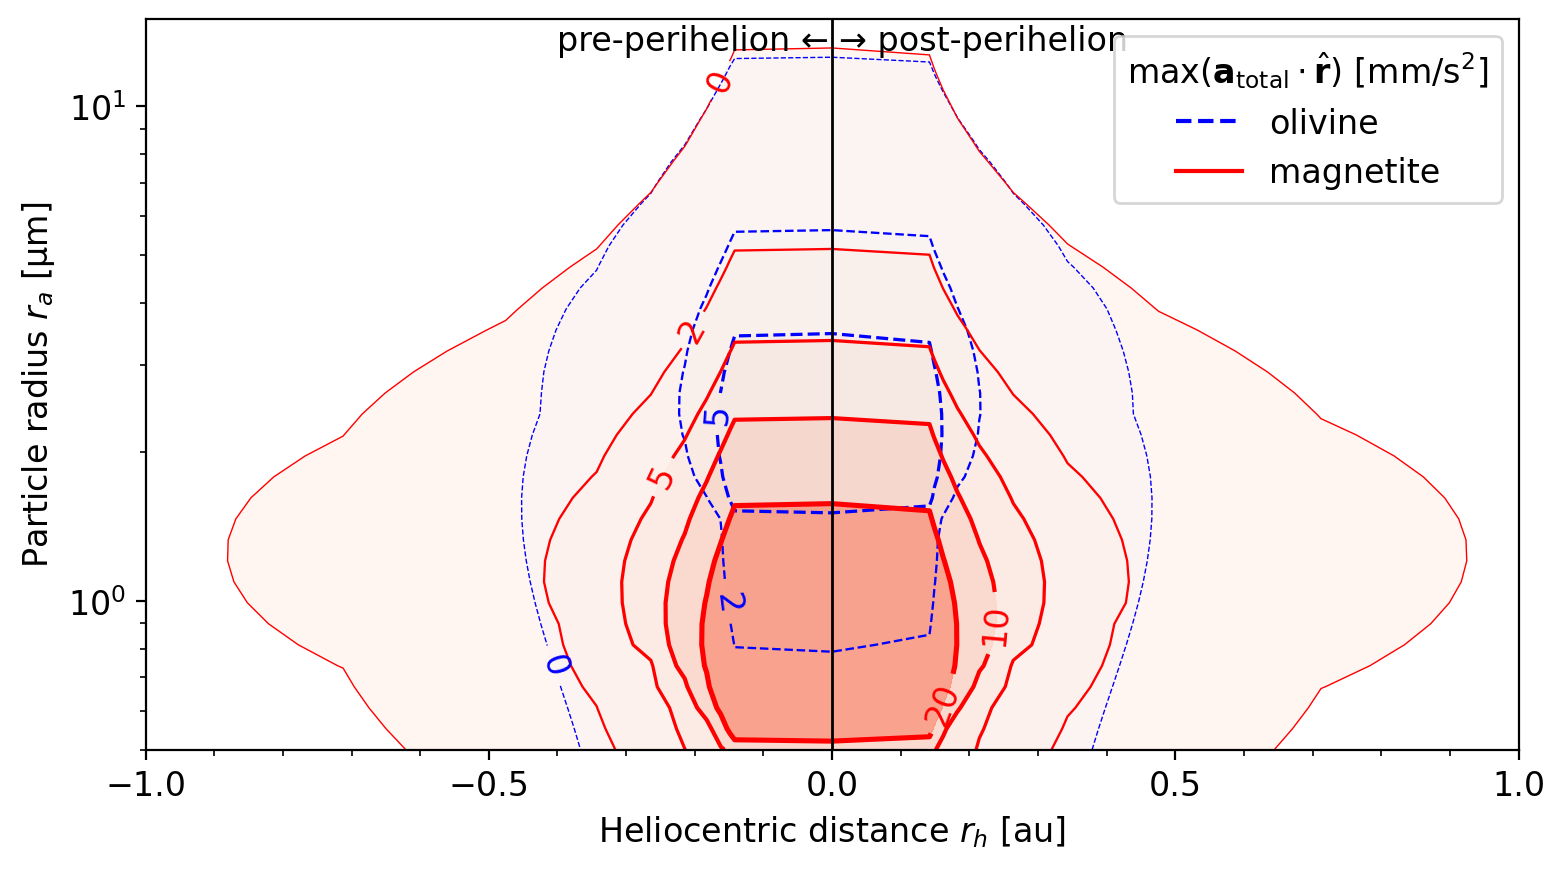

In [11]:
kws = dict(
    o=dict(c='b', lab='olivine', ls='--', cmap='Blues', calpha=1),
    m=dict(c='r', lab='magnetite', ls='-', cmap='Reds', calpha=0.7),
)
lvs = [0.01, 2, 5, 10, 20, 50, 80]
lws = .5 + np.arange(len(lvs))/3

r_hel = set_spl()['rh']

fig, axs = plt.subplots(1, 1, figsize=(8, 4.5), 
                        sharex=True, sharey=False)#, gridspec_kw={'height_ratios':[5, 2]})
axa = axs

x = r_hel(wrap_180180_to_000360(a_phae.f)) * np.sign(a_phae.f)
y = a_phae.r
m_phae = set_phaethon()
a_cen = (m_phae.radi_eff * m_phae.rot_omega**2).si.value

# m/s^2 to mm/s^2
max_o = 1000*(a_cen + a_phae.h18.sel(chem='oliv', th=90).max(dim='ph').T)
max_m = 1000*(a_cen + a_phae.h18.sel(chem='mag', th=90).max(dim='ph').T)

axa.set(yscale='log', 
        xlim=(-1, 1),
        ylim=(0.5, 15),
        ylabel='Particle radius $r_a$ [µm]',
        xlabel="Heliocentric distance $r_h$ [au]"
       )

for k, arr in zip(['o', 'm'], [max_o, max_m]):
    c = kws[k]['c']
    l = kws[k]['lab']
    ls = kws[k]['ls']
    cm = kws[k]['cmap']
    ca = kws[k]['calpha']
    axa.contourf(x, y, arr, levels=lvs, cmap=cm, alpha=ca)
    cs = axa.contour(x, y, arr, levels=lvs, linewidths=lws, 
                     colors=c, linestyles=ls)
    cs.clabel(fmt="%.0f", colors=c)
    axa.plot(np.nan, np.nan, f"{c}{ls}", label=l)

axa.legend(loc=1, title=r"$\mathrm{max}(\mathbf{a}_\mathrm{total} \cdot \hat{\mathbf{r}}) ~[\mathrm{mm/s^2}]$")

axa.text(-0.4, 13, "pre-perihelion ←")
axa.text(+0.01, 13, "→ post-perihelion")
axa.axvline(0, lw=1, color='k')
logyticker(axa, xmajlockws=0.5, xminlockws=0.1, xmajgrids=False, ymajgrids=False, xmingrids=False, ymingrids=False)

plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)

# plt.savefig(FIGDIR/"phae_acc_eq.pdf")
# plt.savefig(FIGDIR/"phae_acc_eq.png", dpi=300)

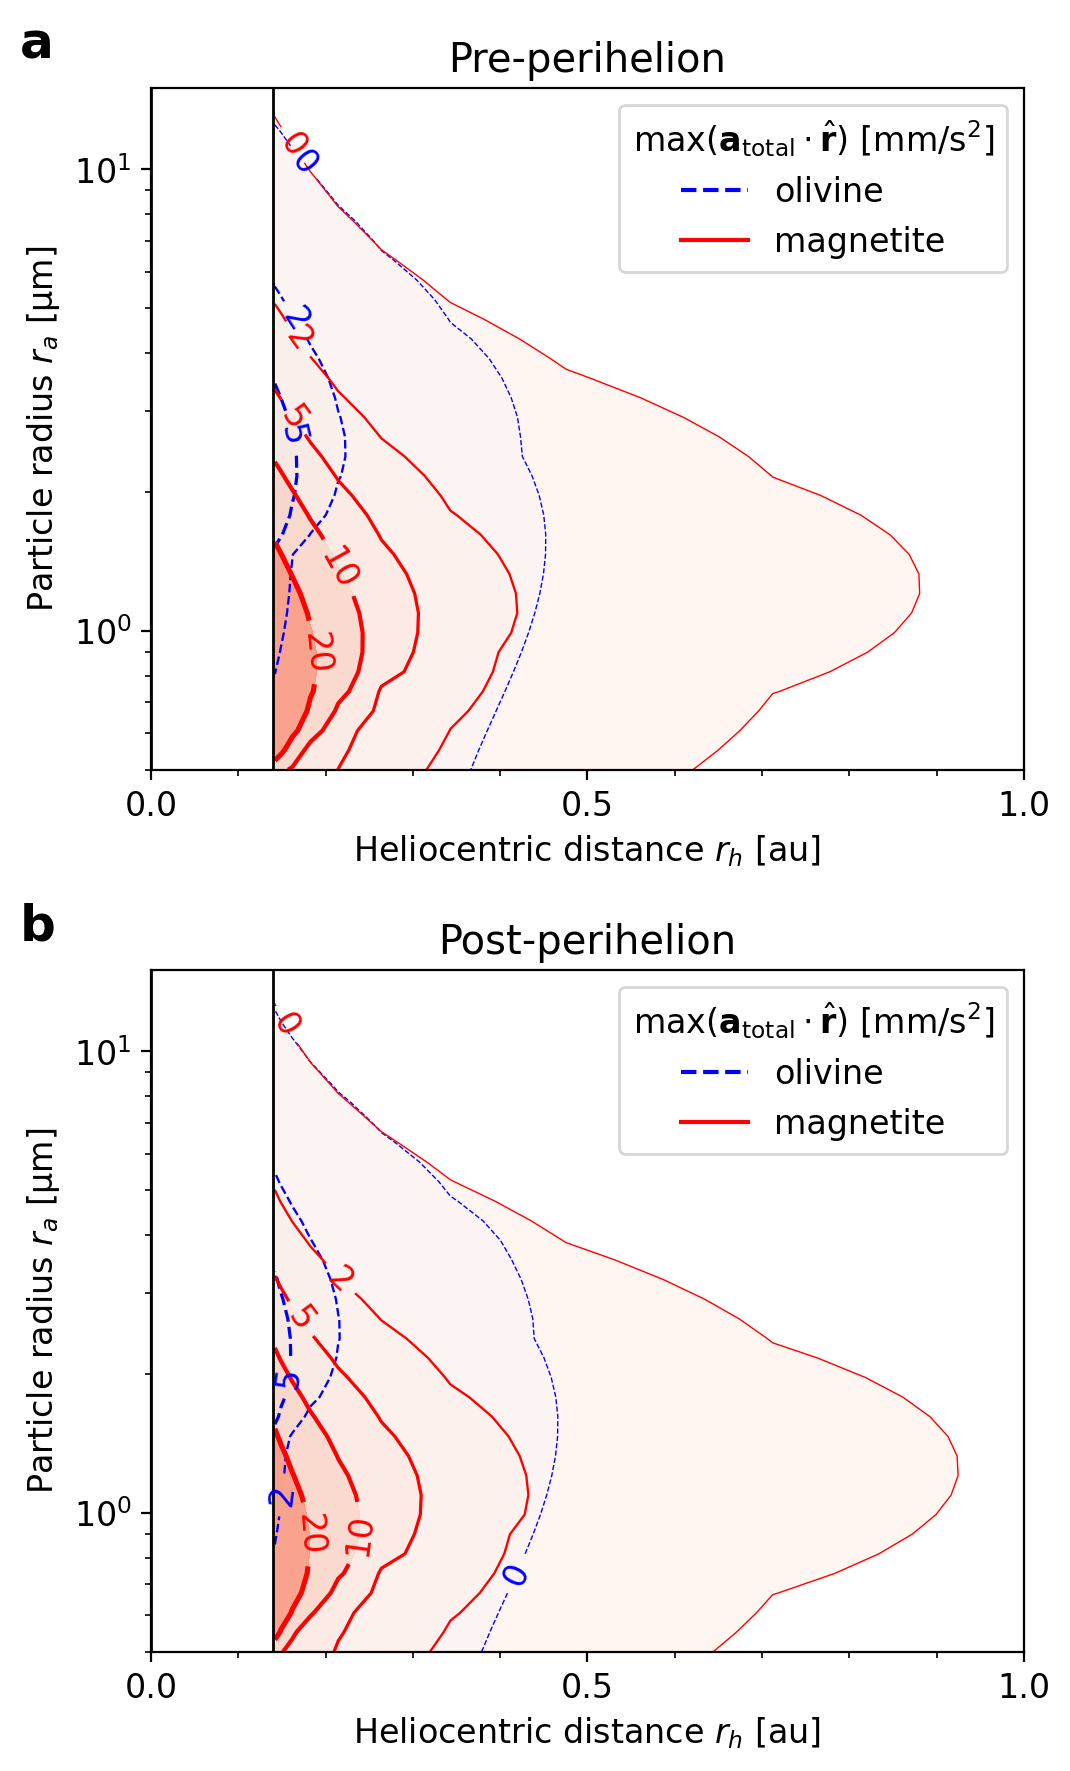

In [12]:
kws = dict(
    o=dict(c='b', lab='olivine', ls='--', cmap='Blues', calpha=1),
    m=dict(c='r', lab='magnetite', ls='-', cmap='Reds', calpha=0.7),
)
lvs = [0.01, 2, 5, 10, 20, 50, 80]
lws = .5 + np.arange(len(lvs))/3


r_hel = set_spl()['rh']

fig, axs = plt.subplots(2, 1, figsize=(5.5, 9))

x = r_hel(wrap_180180_to_000360(a_phae.f)) * np.sign(a_phae.f)
y = a_phae.r
m_phae = set_phaethon()
a_cen = (m_phae.radi_eff * m_phae.rot_omega**2).si.value

# m/s^2 to mm/s^2
max_o = 1000*(a_cen + a_phae.h18.sel(chem='oliv', th=90).max(dim='ph').T)
max_m = 1000*(a_cen + a_phae.h18.sel(chem='mag', th=90).max(dim='ph').T)

axs[0].set(
    yscale='log',
    ylim=(0.5, 15),
    xlim=(0., 1),
    title="Pre-perihelion",
    ylabel='Particle radius $r_a$ [µm]',
    xlabel="Heliocentric distance $r_h$ [au]"
)
axs[1].set(
    yscale='log',
    ylim=(0.5, 15),
    xlim=(0., 1),
    title="Post-perihelion",
    xlabel="Heliocentric distance $r_h$ [au]",
    ylabel='Particle radius $r_a$ [µm]',
)

for k, arr in zip(['o', 'm'], [max_o, max_m]):
    c = kws[k]['c']
    l = kws[k]['lab']
    ls = kws[k]['ls']
    cm = kws[k]['cmap']
    ca = kws[k]['calpha']
    for axa, xidx in zip(axs.tolist(), [slice(0, len(x)//2), slice(len(x)//2 + 1, -1)]):
        axa.contourf(np.abs(x[xidx]), y, arr[:, xidx], levels=lvs, cmap=cm, alpha=ca)
        cs = axa.contour(np.abs(x[xidx]), y, arr[:, xidx],  levels=lvs, linewidths=lws, 
                         colors=c, linestyles=ls)
        cs.clabel(fmt="%.0f", colors=c)
        axa.plot(np.nan, np.nan, f"{c}{ls}", label=l)

for axa in axs.tolist():
    axa.legend(loc=1, title=r"$\mathrm{max}(\mathbf{a}_\mathrm{total} \cdot \hat{\mathbf{r}}) ~[\mathrm{mm/s^2}]$")
    axa.axvline(0, lw=1, color='k')
    axa.axvline(0.14, lw=1, color='k')
    axa.axvline(-0.14, lw=1, color='k')
    logyticker(axa, xmajlockws=0.5, xminlockws=0.1, xmajgrids=False, ymajgrids=False, xmingrids=False, ymingrids=False)

for i, ax in enumerate(axs.flatten()):
    ax.text(x=-0.15, y=1.03, s=chr(ord('a') + i), transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='bottom', ha='left')

plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)

plt.savefig(FIGDIR/"phae_acc_eq.pdf")
plt.savefig(FIGDIR/"phae_acc_eq.png", dpi=300)

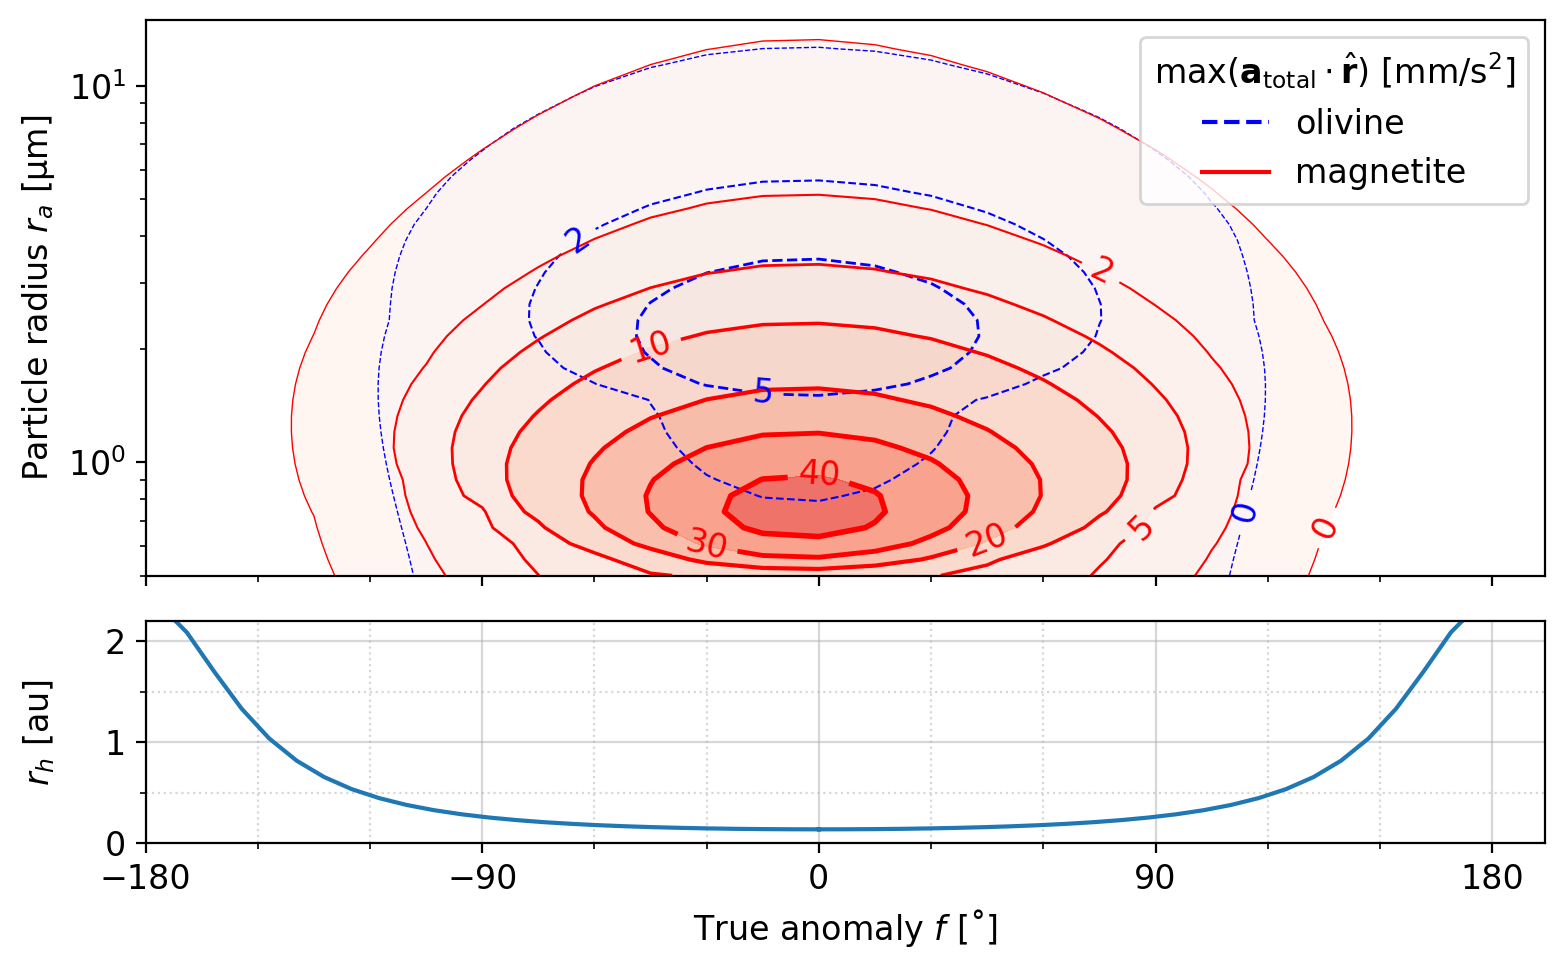

In [13]:
kws = dict(
    o=dict(c='b', lab='olivine', ls='--', cmap='Blues', calpha=1),
    m=dict(c='r', lab='magnetite', ls='-', cmap='Reds', calpha=0.7),
)
lvs = [0, 2, 5, 10, 20, 30, 40, 60, 80]
lws = .5 + np.arange(len(lvs))/4

r_hel = set_spl()['rh']

fig, axs = plt.subplots(2, 1, figsize=(8, 5), 
                        sharex=True, sharey=False, gridspec_kw={'height_ratios':[5, 2]})
axa, axr = axs.tolist()

x = a_phae.f
y = a_phae.r
a_cen = (m_phae.radi_eff * m_phae.rot_omega**2).si.value

# m/s^2 to mm/s^2
max_o = 1000*(a_cen + a_phae.h18.sel(chem='oliv', th=90).max(dim='ph').T)
max_m = 1000*(a_cen + a_phae.h18.sel(chem='mag', th=90).max(dim='ph').T)
axa.set(yscale='log', 
        ylim=(0.5, 15),
        ylabel='Particle radius $r_a$ [µm]',
       )

axr.set(xlabel='True anomaly $f$ [˚]',
        ylabel='$r_h$ [au]', 
        ylim=(0, 2.2), )
for k, arr in zip(['o', 'm'], [max_o, max_m]):
    c = kws[k]['c']
    l = kws[k]['lab']
    ls = kws[k]['ls']
    cm = kws[k]['cmap']
    ca = kws[k]['calpha']
    axa.contourf(x, y, arr, levels=lvs, cmap=cm, alpha=ca)
    cs = axa.contour(x, y, arr, levels=lvs, linewidths=lws, 
                     colors=c, linestyles=ls)
    cs.clabel(fmt="%.0f", colors=c)
    axa.plot(np.nan, np.nan, f"{c}{ls}", label=l)

# axr.xaxis.set_tick_params(labelbottom=False)
axr.plot(wrap_000360_to_180180(np.linspace(0, 360)), r_hel(np.linspace(0, 360)))

axa.legend(loc=1, title=r"$\mathrm{max}(\mathbf{a}_\mathrm{total} \cdot \hat{\mathbf{r}}) ~[\mathrm{mm/s^2}]$")

logyticker(axa, xmajlockws=90, xminlockws=30, xmajgrids=False, ymajgrids=False, xmingrids=False, ymingrids=False)
linticker(axr, 
          ymajlockws=1, yminlockws=0.5, 
          xmajlockws=90, xminlockws=30)

# plt.suptitle("Phaethon, equator", y=1.03)
plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)

## Timing Benchmark

The contents below is purely for the author(Yoonsoo)'s legacy purpose. Please ignore this part.

In [14]:
rh = 0.2
diam_eff = 1000
rot_per = 6

sb_perp = set_model_aspect(r_hel=rh, aspect_deg=90, 
                           diam_eff=diam_eff, rot_period=rot_per, 
                           **TPM_BASE)
sb_th45 = set_model_aspect(r_hel=rh, aspect_deg=45, 
                           diam_eff=diam_eff, rot_period=rot_per, 
                           **TPM_BASE)
sb_perp.calc_temp(full=False)
sb_th45.calc_temp(full=False)

In [15]:
%%timeit
a_perps = {}
a_th45s = {}
a_phaes = {}

for chem in chemkeys[:1]:
    # Splining Qprbar is the most time-consuming part (~ 20ms)
    # compared to all others (< 1ms), so better to give a priori if possible.
    kw_Q = dict(Qprbar_sun=QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv"), 
                Qprbar_ther=QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv"))
    for d in DIAMS[:1]:
        for p in PROTS[:1]:
            for r in RADII[:1]:
                acc_perp = []
                acc_th45 = []
                for ph in PH_0_CALC:
                    kw_p = dict(radius_um=r, chem=chem, 
                                init_th=90, init_ph=ph, **kw_Q)
                    particle_perp = set_particle(sb_perp, **kw_p)
                    particle_th45 = set_particle(sb_th45, **kw_p)
                    a_perp = np.sum(particle_perp.trace_a_all_xyz[-1]
                                    *particle_perp.trace_rvec[-1])
                    a_th45 = np.sum(particle_th45.trace_a_all_xyz[-1]
                                    *particle_th45.trace_rvec[-1])
                    acc_perp.append(a_perp)
                    acc_th45.append(a_th45)
                a_perps[d, p, r] = np.array(acc_perp)
                a_th45s[d, p, r] = np.array(acc_th45)

454 ms ± 33.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# Estimated time for calculation for all radii
len(RADII) * 0.448  # cuz I got 448 ms from above

22.400000000000002

In [17]:
import time
npools = np.arange(15) + 1
times = []
for npool in npools:
    print(npool, end=' ')
    start = time.time()
    a_perps = {}
    a_th45s = {}
    a_phaes = {}

    for chem in chemkeys[:1]:
        # Splining Qprbar is the most time-consuming part (~ 20ms)
        # compared to all others (< 1ms), so better to give a priori if possible.
        kw_Q = dict(Qprbar_sun=QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv"), 
                    Qprbar_ther=QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv"))
        for d in DIAMS[:1]:
            for p in PROTS[:1]:
                def _acc_multi(radius):  # d, p, sb are already defined outside.
                    acc_perp = []
                    acc_th45 = []
                    for ph in PH_0_CALC:
                        kw_p = dict(radius_um=radius, chem=chem, 
                                    init_th=90, init_ph=ph, **kw_Q)
                        particle_perp = set_particle(sb_perp, **kw_p)
                        particle_th45 = set_particle(sb_th45, **kw_p)
                        a_perp = np.sum(particle_perp.trace_a_all_xyz[-1]
                                        * particle_perp.trace_rvec[-1])
                        a_th45 = np.sum(particle_th45.trace_a_all_xyz[-1]
                                        * particle_th45.trace_rvec[-1])
                        acc_perp.append(a_perp)
                        acc_th45.append(a_th45)
                    return radius, np.array(acc_perp), np.array(acc_th45)

                pool = Pool(npool)
                args = [RADII]
                results = np.array(pool.starmap(_acc_multi, np.array(args).T))
                pool.close()

                for res in results:
                    a_perps[d, p, res[0]*u.um] = res[1]
                    a_th45s[d, p, res[0]*u.um] = res[1]
    times.append(time.time() - start)

1 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/ysbach/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-cd391db829e0>", line 36, in <module>
    results = np.array(pool.starmap(_acc_multi, np.array(args).T))
  File "/Users/ysbach/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 372, in starmap
    return self._map_async(func, iterable, starmapstar, chunksize).get()
  File "/Users/ysbach/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 765, in get
    self.wait(timeout)
  File "/Users/ysbach/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 762, in wait
    self._event.wait(timeout)
  File "/Users/ysbach/opt/anaconda3/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/Users/ysbach/opt/anaconda3/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

Dur

TypeError: object of type 'NoneType' has no len()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5), 
                        sharex=False, sharey=False, gridspec_kw=None)
axs.plot(npools, times)
axs.axhline(0.448*len(RADII), color='k', lw=1, label='single thread')  # single thread time
axs.set(xlabel="Npools", ylabel="Time [s]")
axs.legend()
plt.tight_layout()
fig.align_ylabels(axs)
fig.align_xlabels(axs)
plt.show()

968So I used ``npool_optimal = 7``.